In [18]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats
from seaborn import heatmap

# Make the graphs a bit prettier, and bigger
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)

# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

# Weather data

In [19]:
raw_data = pd.read_csv("data/LYBE.26.09.2012.03.04.2021.1.0.0.en.utf8.00000000.csv", sep=",", low_memory=True)
weather_data = pd.DataFrame()
raw_data.head()

,Local time in Belgrade / Nicola Tesla (airport),T,P0,P,U,DD,Ff,ff10,WW,W'W',c,VV,Td
0,03.04.2021 16:00,9.0,751.2,760.5,82.0,Wind blowing from the west,6.0,NaN,NaN,NaN,Few clouds (10-30%) 900 m,10.0 and more,6.0
1,03.04.2021 15:30,9.0,751.2,760.5,82.0,Wind blowing from the west-southwest,5.0,NaN,Light rain,NaN,Broken clouds (60-90%) 900 m,10.0 and more,6.0
2,03.04.2021 15:00,8.0,751.8,761.2,87.0,Wind blowing from the south-west,3.0,NaN,Light rain,NaN,"Few clouds (10-30%) 600 m, broken clouds (60-9...",7,6.0
3,03.04.2021 14:30,8.0,751.8,761.2,87.0,Wind blowing from the west-southwest,4.0,NaN,Light rain,NaN,"Scattered clouds (40-50%) 600 m, broken clouds...",7,6.0
4,03.04.2021 14:00,8.0,751.8,761.2,87.0,Wind blowing from the west-southwest,5.0,NaN,Light rain,NaN,"Scattered clouds (40-50%) 450 m, broken clouds...",6,6.0


# Preprocessing

In [20]:
def datetime2ymd(in_df, out_df):
    out_df["year"]  = in_df["DateTime"].astype(str).str[:4].astype(int)
    out_df["month"] = in_df["DateTime"].astype(str).str[5:7].astype(int)
    out_df["day"]   = in_df["DateTime"].astype(str).str[8:10].astype(int)
    out_df["hour"]  = in_df["DateTime"].astype(str).str[11:13].astype(int)
    out_df["min"]   = in_df["DateTime"].astype(str).str[14:].astype(int)
    
    return out_df

def datetime2dmy(in_df, out_df):
    out_df["year"]  = in_df["DateTime"].astype(str).str[6:10].astype(int)
    out_df["month"] = in_df["DateTime"].astype(str).str[3:5].astype(int)
    out_df["day"]   = in_df["DateTime"].astype(str).str[:2].astype(int)
    out_df["hour"]  = in_df["DateTime"].astype(str).str[11:13].astype(int)
    out_df["min"]   = in_df["DateTime"].astype(str).str[14:].astype(int)
    
    return out_df

In [21]:
raw_data["DateTime"] = raw_data["Local time in Belgrade / Nicola Tesla (airport)"]
weather_data = datetime2dmy(raw_data, weather_data)

In [22]:
copy_columns = ["T", "P0", "P", "U", "Td"]
weather_data[copy_columns] = raw_data[copy_columns]

In [23]:
weather_data["VV"] = raw_data["VV"]
weather_data.loc[raw_data.VV == "10.0 and more", "VV"] = 10

#### Smaller one-hot

In [24]:
ww_data = pd.DataFrame(raw_data.WW.str.lower().str.split(',')).fillna("")

weather_data["mist"] = pd.DataFrame([int("mist" in x) for x in ww_data.WW])
weather_data["rain"] = pd.DataFrame([int("rain" in x) for x in ww_data.WW])
weather_data["light_rain"] = pd.DataFrame([int("light rain" in x) for x in ww_data.WW])
weather_data["fog"] = pd.DataFrame([int("fog" in x) for x in ww_data.WW])
weather_data["heavythunderstorm"] = pd.DataFrame([int("heavy thunderstorm" in x) for x in ww_data.WW])
weather_data["snow"] = pd.DataFrame([int("snow" in x) for x in ww_data.WW])
weather_data["smoke"] = pd.DataFrame([int("smoke" in x) for x in ww_data.WW])
weather_data["thunderstorm"] = pd.DataFrame([int("thunderstorm" in x) for x in ww_data.WW])
weather_data["duststorm"] = pd.DataFrame([int("duststorm" in x) for x in ww_data.WW])

In [25]:
weather_data = pd.concat([weather_data, pd.get_dummies(raw_data.DD)], axis=1)

In [26]:
weather_data

,year,month,day,hour,min,T,P0,P,U,Td,VV,mist,rain,light_rain,fog,heavythunderstorm,snow,smoke,thunderstorm,duststorm,"Calm, no wind",Wind blowing from the east,Wind blowing from the east-northeast,Wind blowing from the east-southeast,Wind blowing from the north,Wind blowing from the north-east,Wind blowing from the north-northeast,Wind blowing from the north-northwest,Wind blowing from the north-west,Wind blowing from the south,Wind blowing from the south-east,Wind blowing from the south-southeast,Wind blowing from the south-southwest,Wind blowing from the south-west,Wind blowing from the west,Wind blowing from the west-northwest,Wind blowing from the west-southwest,variable wind direction
0,2021,4,3,16,0,9.0,751.2,760.5,82.0,6.0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2021,4,3,15,30,9.0,751.2,760.5,82.0,6.0,10,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2021,4,3,15,0,8.0,751.8,761.2,87.0,6.0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,2021,4,3,14,30,8.0,751.8,761.2,87.0,6.0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2021,4,3,14,0,8.0,751.8,761.2,87.0,6.0,6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136804,2012,9,26,13,0,29.0,751.8,760.5,33.0,11.0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
136805,2012,9,26,12,0,28.0,751.8,760.5,35.0,11.0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
136806,2012,9,26,11,0,26.0,751.7,760.5,39.0,11.0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
136807,2012,9,26,10,0,24.0,751.6,760.5,50.0,13.0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


## Load Target Data

In [27]:
target_df = pd.read_csv("data/MATF_Hackathon_2021/SviPodaci_mStanica_BeogradNBG.csv")
clean_target = pd.DataFrame()

target_df = target_df.rename(columns={"Datum_i_Vreme": "DateTime"})

clean_target = datetime2ymd(target_df, clean_target)
copy_columns = ["B", "CO", "NO2", "O3", "PM10", "PM25", "SO2"]

clean_target[copy_columns] = target_df[copy_columns]
clean_target = clean_target.sort_values(by=["year", "month", "day", "hour", "min"])

clean_target.head()

,year,month,day,hour,min,B,CO,NO2,O3,PM10,PM25,SO2
23026,2009,11,17,20,0,NaN,NaN,NaN,NaN,NaN,54.221211,NaN
28045,2009,11,17,21,0,NaN,NaN,NaN,NaN,NaN,61.848214,NaN
52868,2009,11,17,22,0,NaN,NaN,NaN,NaN,NaN,47.386997,NaN
68772,2009,11,17,23,0,NaN,NaN,NaN,NaN,NaN,42.317648,NaN
41525,2009,11,18,0,0,NaN,NaN,NaN,NaN,NaN,41.457331,NaN


In [28]:
final_data = weather_data.merge(clean_target)

In [29]:
final_data.to_csv('data/training_test_data.csv')

## Data ploting

#### By Hour

Text(0.5, 0, 'Hour')

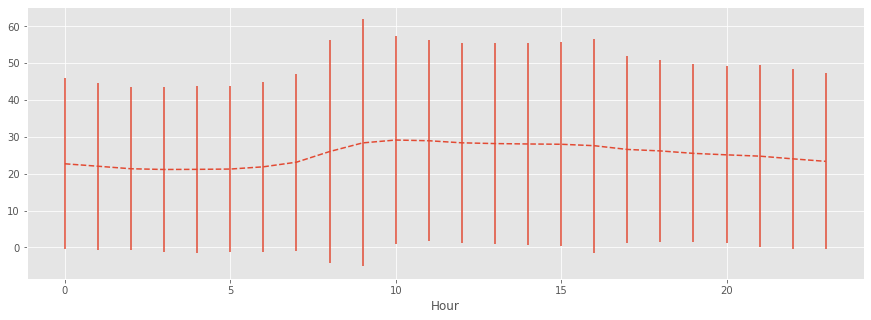

In [30]:
month = clean_target.loc[
    (clean_target["year"].isin([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])) &
    (clean_target["month"].isin([10, 11, 12, 1, 2]))
]

polution_by_hour = []
std_by_hour = []
for hour in range(24):
    polution_by_hour.append(month.loc[month["hour"] == hour].mean()["SO2"])
    std_by_hour.append(month.loc[month["hour"] == hour].std()["SO2"])
    
plt.errorbar(list(range(24)), polution_by_hour, std_by_hour, linestyle="--")
plt.xlabel("Hour")

#### By Month

Text(0.5, 0, 'Month')

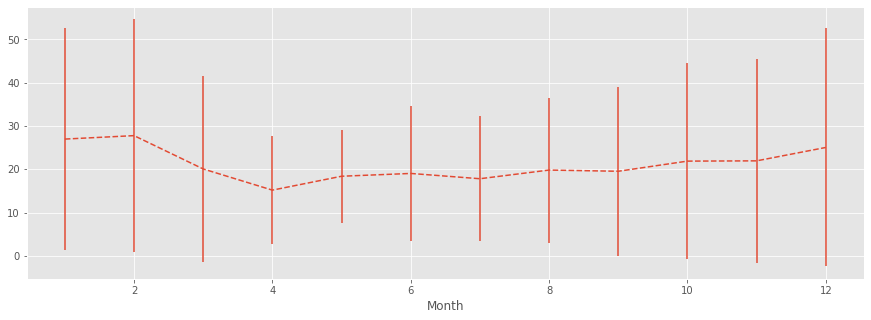

In [31]:
years = clean_target.loc[
    (clean_target["year"].isin([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]))
]

polution_by_month = []
std_by_month = []
for mth in range(1, 13):
    polution_by_month.append(years.loc[years["month"] == mth].mean()["SO2"])
    std_by_month.append(years.loc[years["month"] == mth].std()["SO2"])
    
plt.errorbar(list(range(1, 13)), polution_by_month, std_by_month, linestyle="--")
plt.xlabel("Month")

### Corelation

<AxesSubplot:>

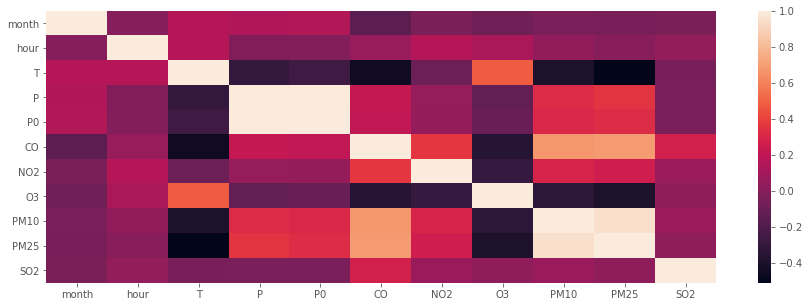

In [32]:
data_of_interest = final_data[["month", "hour", "T", "P", "P0", "VV", "CO", "NO2", "O3", "PM10", "PM25", "SO2"]]
heatmap(data_of_interest.corr())

In [33]:
data_of_interest.corr().to_csv('data/correlations.csv')

## AQI

In [34]:
def calculate_aqi(data):
    
    boundaries = {
    "PM10" : [0, 50, 100, 250, 350, 430],
    "PM25" : [0, 30, 60, 90, 120, 250],
    "NO2" : [0, 40, 80, 180, 280, 400],
    "O3" : [0, 50, 100, 168, 208, 748],
    "CO" : [0, 1, 2, 10, 17, 34],
    "SO2" : [0, 40, 80, 380, 800, 1600],
    "AQI" : [0, 50, 100, 200, 300, 400, 500]
    }

    pollusions = ["CO", "NO2", "O3", "PM10", "PM25", "SO2"]

    aqi_max = 0
    for pol in pollusions:
        j = len(boundaries[pol])-1
        if data[pol] == -1:
            continue
        while data[pol] < boundaries[pol][j]:
            j-=1
        low_index = j
        high_index = j+1
        if high_index < len(boundaries[pol]):
            delta_boundaries = boundaries[pol][high_index] - boundaries[pol][low_index]
        else:
            delta_boundaries = boundaries[pol][low_index] - boundaries[pol][low_index-1]
        aqi = ((boundaries["AQI"][high_index] - boundaries["AQI"][low_index]) / \
                 delta_boundaries) * \
                (data[pol] - boundaries[pol][low_index]) + boundaries["AQI"][low_index]
        if aqi > aqi_max:
            aqi_max = aqi
    return aqi_max

In [35]:
df = pd.read_csv('data/training_test_data.csv')

#### By Day

In [36]:
daily_pred = pd.DataFrame()
daily_pred = df.loc[(df["year"] == 2021) & (df["month"] == 2) & (df["day"] == 10),
                    ["hour", "B", "CO", "NO2", "O3", "PM10", "PM25", "SO2"]]
daily_pred = pd.DataFrame(daily_pred)
aqi = pd.DataFrame({'AQI': [calculate_aqi(daily_pred.iloc[i]) for i in range(daily_pred.shape[0])]})
daily_pred["AQI"] = aqi["AQI"].values

In [37]:
daily_pred.to_csv('data/website_daily.csv')

#### By Month

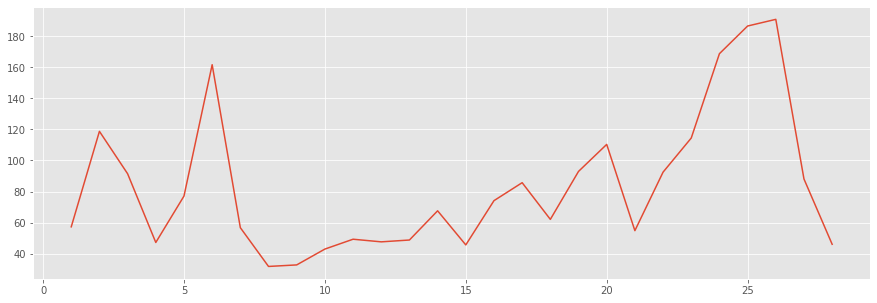

In [38]:
monthly_obs = pd.DataFrame()
monthly_obs = df.loc[(df["year"] == 2021) & (df["month"] == 2),
                    ["day", "B", "CO", "NO2", "O3", "PM10", "PM25", "SO2"]]

monthly_obs = monthly_obs.groupby('day').mean()

aqi = pd.DataFrame({'AQI': [calculate_aqi(monthly_obs.iloc[i]) for i in range(monthly_obs.shape[0])]})
monthly_obs["AQI"] = aqi["AQI"].values

plt.plot(monthly_obs["AQI"])

In [39]:
monthly_obs.to_csv('data/website_monthly.csv')

#### By Year

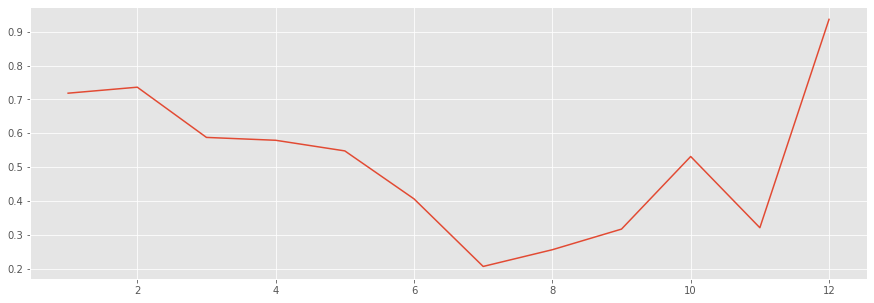

In [40]:
year_obs = pd.DataFrame()
year_obs = df.loc[(df["year"] == 2019),
                    ["month", "B", "CO", "NO2", "O3", "PM10", "PM25", "SO2"]]

year_obs = year_obs.groupby('month').mean()

aqi = pd.DataFrame({'AQI': [calculate_aqi(year_obs.iloc[i]) for i in range(year_obs.shape[0])]})
year_obs["AQI"] = aqi["AQI"].values


plt.plot(year_obs["CO"])

In [41]:
year_obs.to_csv('data/website_yearly.csv')